# Assignment 3 - Stochastic Processes

    Name: Clara Periago
    Student #: s1067476

In [ ]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.experimental import io_callback
from pathlib import Path
import shutil
import glob
import fastplotlib as fpl
import numpy as np

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅ (default),Apple M3 Max,IntegratedGPU,Metal,


In [2]:
# these are copy pasted from the last exercise
def rk4(f, dt):
    @jax.jit
    def step(x, t):
        k1 = f(t, x)
        k2 = f(t + .5 * dt, x + .5 * dt * k1)
        k3 = f(t + .5 * dt, x + .5 * dt * k2)
        k4 = f(t + dt, x + dt * k3)

        xn1 = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
        return xn1

    return step

# helper wrapper that takes a step solver, initial conditions and time domain
def simulate(solver, c0, t):
    def iterate(c, t):
        xn1 = solver(c, t)
        # return xn1, xn1
        io_callback(save_frame_to_host, None, xn1, t)
        return xn1, None
    
    _, xs = jax.lax.scan(iterate, c0, t)
    return xs


In [3]:
lapl = jnp.array(
    [[0.05, 0.2, 0.05],
     [0.2, -1.0, 0.2],
     [0.05, 0.2, 0.05]]
)
dx = 2.
lapl = lapl / (dx * dx)

def draw_fn(ax, grid):
    A, B = grid
    ax.imshow((B / (A + B)).T, cmap='Spectral')

def diffuse(k_i, dk):
    return dk * jax.scipy.signal.convolve2d(k_i, lapl, mode="same", boundary="fill", fillvalue=0)

def step_n(n):
    def _step(x):
        def body(x, _):
            return solver(x, 0.0), None
        x, _ = jax.lax.scan(body, x, None, length=n)
        return x
    return _step

def bunny_dynamics(dK, dt, feed, kill, reproduction):
    def f(t, c):
        K = c  # (k, w, h)
        G, B = K # Grass, Bunny
        # G, B = jnp.clip(K, 0, 1) # Grass, Bunny

        H = 0.01
        K_G = 1.0 - 0.5 * H

        bunnies_reproduced = reproduction * G * B**2

        next_K = jnp.array([
            feed * (K_G - G) - bunnies_reproduced,
            - (kill + feed) * B + bunnies_reproduced + .01 * reproduction * G * B,
        ])
        #next_K = jnp.zeros_like(K)

        k_diffused = jax.vmap(diffuse, in_axes=(0, 0))(K, dK)

        next_K = k_diffused + next_K
        
        return next_K
    
    def gup(x, t):
        return f(t, x)
 
    solver = jax.jit(rk4(f, dt))
    # solver = gup

    return solver

def draw_circle(grid, cx, cy, radius, strength, channel=1):
    """
    grid: (C, W, H)
    cx, cy: center coordinates
    radius: circle radius
    value: value to write inside the circle
    channel: which channel to write to
    """
    _, w, h = grid.shape

    xs = jnp.arange(w)[:, None]
    ys = jnp.arange(h)[None, :]

    # mask = (xs - cx)**2 + (ys - cy)**2 <= radius**2
    dist2 = (xs - cx)**2 + (ys - cy)**2
    brush = jnp.exp(-dist2 / (2 * radius**2))

    return grid.at[channel].add(strength * brush)


    # return grid.at[channel].set(
    #     jnp.where(mask, value, grid[channel])
    # )


In [4]:
dt = 1.
t = jnp.arange(0, 5000, dt)
dK = jnp.array([1.0, 0.5])
w, h = 320, 320
wh = jnp.array([w, h])

grid = jnp.stack(
    [
        jnp.ones(shape=(w, h)),#, dtype=jnp.uint8),
        jnp.zeros(shape=(w, h))#, dtype=jnp.uint8)
    ]
)

seed_size = 11
key = jr.key(42)
seed_locations = jr.uniform(key, shape=(seed_size, 2), minval=0., maxval=wh)
# grid = grid.at[
#     1,
#     int(w / 2) - int(seed_size / 2) : int(w / 2) + int(seed_size / 2) + 1,
#     int(h / 2) - int(seed_size / 2) : int(h / 2) + int(seed_size / 2) + 1,
# ].set(.4*jnp.ones((seed_size, seed_size)))#, dtype=jnp.uint8) * 255)
for x, y in seed_locations:
    grid = draw_circle(grid, x, y, 2, .6, channel=1)
# grid = draw_circle(grid, w//2-5, h//2-5, 5, .4, channel=1)

solver = bunny_dynamics(dK, dt, .0367, .0649, 1.)
s0 = grid  # initial state

RFBOutputContext()

JupyterRenderCanvas(css_height='560.0px', css_width='700.0px')
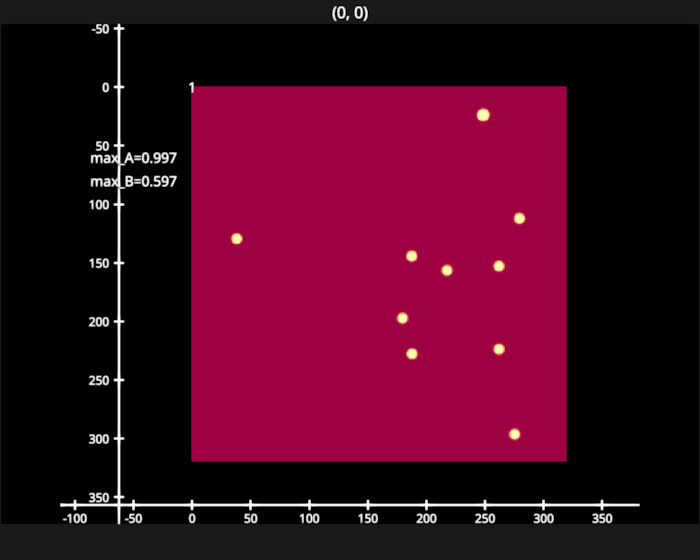

In [5]:
fig = fpl.Figure(size=(700, 560))
fig.canvas.max_buffered_frames = 1
data = jnp.zeros((320, 320))
image = fig[0, 0].add_image(data=data, name="random-image", cmap="Spectral", vmin=0., vmax=1.)
fig[0, 0].add_text(text="0", name="frame")
fig[0, 0].add_text(text="0", name="max_A", offset=(-50,60, 0))
fig[0, 0].add_text(text="0", name="max_B", offset=(-50, 80, 0))
marker_index = 0
current_x = s0
STEPS_PER_FRAME = 20
stepper = jax.jit(step_n(STEPS_PER_FRAME))

def resample01(arr):
    mx = arr.max()
    mn = arr.min()
    return (arr - mn) / (mx - mn)

# a function to update the image
# a figure-level animation function will optionally take the figure as an argument
def update_data():
    global marker_index, current_x
    marker_index += 1

    if marker_index == t.shape[0]:
        marker_index = 0

    current_x = stepper(current_x)

    cmap = plt.get_cmap("Spectral")

    A, B = jnp.clip(current_x, 0, 1)
    frame = B
    #frame = resample01(frame)
    #rgb = (cmap(frame)[..., :3] * 255).astype(jnp.uint8)
    
    fig[0, 0]["random-image"].data = frame
    fig[0, 0]["frame"].text = str(marker_index)
    fig[0, 0]["max_A"].text = f"max_A={jnp.max(A):.3f}"
    fig[0, 0]["max_B"].text = f"max_B={jnp.max(B):.3f}"

@image.add_event_handler("pointer_down")
def click_event(ev):
    global current_x
    # get the click location in screen coordinates
    xy = (ev.x, ev.y)

    # map the screen coordinates to world coordinates
    xy = fig[0, 0].map_screen_to_world(xy)[:-1]
    y, x = jnp.array(xy, dtype=int)

    # print the click location
    current_x = draw_circle(current_x, x, y, 2, .3, channel=1)
    print(x, y)

# you can also add animation functions to individual subplots
def update_data_subplot(subplot_instance):
    pass

# add this as an animation function
fig.add_animations(update_data)

# similarly you can add animation function to a subplot
# fig[0, 0].add_animations(update_data_subplot)

# show the plot
fig.show()

RFBOutputContext()

JupyterRenderCanvas(css_height='560.0px', css_width='700.0px')
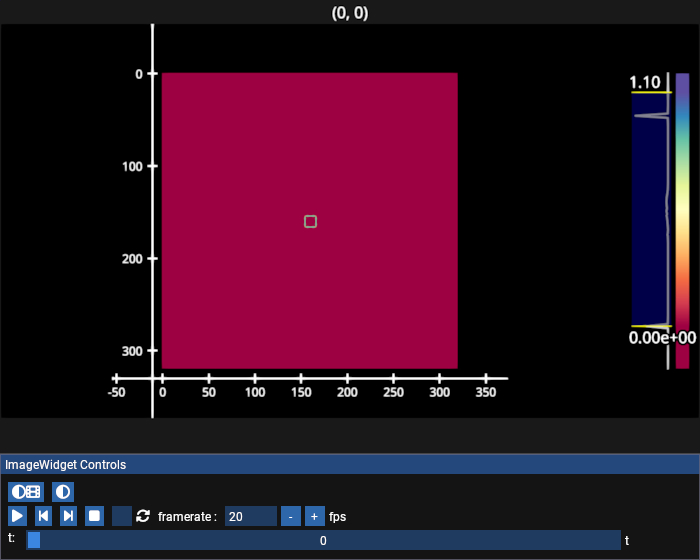

In [328]:
frames = xyz_history[:, 1] / (xyz_history[:, 0] + xyz_history[:, 1])

iw = fpl.ImageWidget(
    data=frames,
    cmap="Spectral",
    figure_kwargs={"size": (700, 560)},
    graphic_kwargs={"vmin": 0.0, "vmax": 1.1},
)
iw.show()